In [ ]:
import pandas as pd

# Use the 'python' engine for more robust parsing, especially with potential errors in data lines
df = pd.read_csv('subject_data.csv', engine='python')
print(df.columns.tolist())

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('download/subject_data.csv')

df.head()

cluster shi

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap, warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('download/subject_data.csv', encoding='utf-8')

# Numeric feature selection
num_cols = df.select_dtypes(include='number').columns.tolist()
if 'target' in num_cols:
    num_cols.remove('target')

# Sample for speed
sample_df = df[num_cols + ['target']].fillna(0).sample(
    n=min(5000, len(df)), random_state=3
)

# Scale numeric features
scaled = StandardScaler().fit_transform(sample_df[num_cols])

# Dimensionality reductions
pca_coords = PCA(n_components=2, random_state=3).fit_transform(scaled)
tsne_coords = TSNE(n_components=2, perplexity=30, random_state=3, init='pca').fit_transform(scaled)
umap_coords = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=3).fit_transform(scaled)

# Colour mapping based on target (0=benign, 1=malignant)
color_map = {0: 'green', 1: 'red'}
colors = sample_df['target'].map(color_map)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].scatter(pca_coords[:, 0], pca_coords[:, 1], c=colors, s=8)
axs[0].set_title('PCA — Benign vs Malignant')

axs[1].scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=colors, s=8)
axs[1].set_title('t-SNE — Benign vs Malignant')

axs[2].scatter(umap_coords[:, 0], umap_coords[:, 1], c=colors, s=8)
axs[2].set_title('UMAP — Benign vs Malignant')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

print('Dimensionality reduction plots coloured by original target values.')


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x78d114e1da80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/llvmlite/binding/executionengine.py", line 178, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap, warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('subject_data.csv', encoding='utf-8')

# Filter only malignant cases
df_mal = df[df['target'] == 1].copy()

# Numeric feature selection
num_cols = df_mal.select_dtypes(include='number').columns.tolist()
if 'target' in num_cols:
    num_cols.remove('target')

# Sample for speed
sample_df = df_mal[num_cols + ['target']].fillna(0).sample(
    n=min(5000, len(df_mal)), random_state=3
)

# Scale numeric features
scaled = StandardScaler().fit_transform(sample_df[num_cols])

# Dimensionality reductions
pca_coords = PCA(n_components=2, random_state=3).fit_transform(scaled)
tsne_coords = TSNE(n_components=2, perplexity=30, random_state=3, init='pca').fit_transform(scaled)
umap_coords = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=3).fit_transform(scaled)

# All malignant — single color
mal_color = 'red'

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].scatter(pca_coords[:, 0], pca_coords[:, 1], c=mal_color, s=8)
axs[0].set_title('PCA — Malignant only')

axs[1].scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=mal_color, s=8)
axs[1].set_title('t-SNE — Malignant only')

axs[2].scatter(umap_coords[:, 0], umap_coords[:, 1], c=mal_color, s=8)
axs[2].set_title('UMAP — Malignant only')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

print('Dimensionality reduction plots generated for malignant cases only.')


In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import hdbscan
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Load data
df = pd.read_csv("subject_data.csv")
features = [c for c in df.select_dtypes(include=[np.number]).columns
            if c not in ['target','isic_id','patient_id'] and not c.startswith('iddx_')]
X = df[features].fillna(-999)

# Scale + PCA to speed up all methods
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pca = PCA(n_components=min(30, X_scaled.shape[1]), random_state=42).fit_transform(X_scaled)

# --- Gaussian Mixture Model ---
lowest_bic, best_gmm = np.inf, None
for n in range(2, 6):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_pca)
    bic = gmm.bic(X_pca)
    if bic < lowest_bic:
        lowest_bic, best_gmm = bic, gmm
df['gmm_cluster'] = best_gmm.predict(X_pca)

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, metric='euclidean')
df['hdbscan_cluster'] = hdb.fit_predict(X_pca)

# --- Spectral Clustering ---
spec = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=15,
                          random_state=42, n_jobs=-1)
df['spectral_cluster'] = spec.fit_predict(X_pca)

# --- Deep Embedding Clustering (DEC) ---
input_dim = X_pca.shape[1]
input_layer = Input(shape=(input_dim,))
enc = Dense(32, activation="relu")(input_layer)
enc = Dense(8, activation="relu")(enc)
dec = Dense(32, activation="relu")(enc)
dec = Dense(input_dim, activation=None)(dec)
autoencoder = Model(inputs=input_layer, outputs=dec)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_pca, X_pca, epochs=15, batch_size=256, shuffle=True, verbose=0)

encoder_model = Model(inputs=input_layer, outputs=enc)
X_encoded = encoder_model.predict(X_pca)
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['dec_cluster'] = kmeans.fit_predict(X_encoded)

# --- Save results ---
df.to_csv("clustering_results_full.csv", index=False)

# --- Evaluate silhouette + malignant proportion ---
for col in ['gmm_cluster', 'hdbscan_cluster', 'spectral_cluster', 'dec_cluster']:
    labels = df[col]
    if len(set(labels)) > 1 and (labels != -1).sum() > 0:
        try:
            sc = silhouette_score(X_pca, labels)
            print(f"{col} silhouette: {round(sc, 4)}")
        except:
            print(f"{col} silhouette: N/A")
    print(df.groupby(col)['target'].mean().rename('Malignant_Proportion'))
    print("-"*50)


/tmp/ipython-input-3983337253.py:14: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("subject_data.csv")
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


EDA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pivot_mean: proportion (0..1)
# pivot_count: raw counts
# mask_low: boolean mask for low-count cells (optional)

plt.figure(figsize=(10, max(4, 0.35 * len(pivot_mean))))
ax = sns.heatmap(pivot_mean.fillna(0), cmap="rocket_r", vmin=0, vmax=1,
                 linewidths=0.5, linecolor='lightgray', cbar_kws={'label':'Proportion malignant'},
                 mask=mask_low)

# Annotate with percent on first line and counts on second line
for i, row in enumerate(pivot_count.index):
    for j, col in enumerate(pivot_count.columns):
        cnt = pivot_count.loc[row, col]
        if pd.isna(cnt) or cnt == 0:
            txt = ""
        else:
            prop = pivot_mean.loc[row, col]
            if pd.isna(prop):
                txt = f"n={int(cnt)}"
            else:
                pct = prop * 100
                txt = f"{pct:.1f}%\n(n={int(cnt)})"
        # pick text color contrasting with background
        bg = pivot_mean.loc[row, col] if (row in pivot_mean.index and col in pivot_mean.columns) else 0
        txt_color = 'white' if not np.isnan(bg) and bg > 0.55 else 'black'
        if txt:
            ax.text(j + 0.5, i + 0.5, txt, ha='center', va='center', color=txt_color, fontsize=8)

# show hatch for masked low-count cells
for (i, j), v in np.ndenumerate(mask_low.values):
    if v:
        rect = plt.Rectangle((j, i), 1, 1, facecolor='none', hatch='////', edgecolor='gray', lw=0.0)
        ax.add_patch(rect)

ax.set_yticklabels(pivot_mean.index, fontsize=9)
ax.set_xticklabels(pivot_mean.columns.astype(str), rotation=45, ha='right')
ax.set_title('Proportion malignant by Anatomical site and Age group (percent and n)')
plt.tight_layout()
plt.show()



In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
import umap
import hdbscan
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency

# CONFIG
DATA = Path("subject_data.csv")
OUT = Path("deep_insights_outputs"); OUT.mkdir(exist_ok=True)
ENABLE_HEAVY = True   # set False to skip SHAP/UMAP/HDBSCAN if low RAM

# LOAD + basic preprocess
df = pd.read_csv(DATA)
df.columns = [c.strip() for c in df.columns]
df.rename(columns={c: c.lower() for c in df.columns}, inplace=True)

# keep numeric features only (drop obvious leakage/ids)
exclude_prefix = ('iddx_',)
exclude_cols = ['isic_id','patient_id']
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols and not c.startswith(exclude_prefix)]
if 'target' not in df.columns:
    raise SystemExit("target column missing")
if 'target' in num_cols:
    num_cols.remove('target')

# simple impute for numeric
imp = SimpleImputer(strategy='median')
Xnum = pd.DataFrame(imp.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Utility saver
def savefig(fname):
    p = OUT / fname
    plt.tight_layout()
    plt.savefig(p, dpi=150)
    plt.close()
    print("saved:", p)

# 1) AGE x SITE heatmap of malignant proportion
if 'age_approx' in df.columns and 'anatom_site_general' in df.columns:
    df['age_group'] = pd.cut(df['age_approx'].fillna(-1),
                             bins=[-1,20,40,60,80,200],
                             labels=['<20','21-40','41-60','61-80','81+'])
    table = df.groupby(['age_group','anatom_site_general'])['target'].agg(['mean','count']).reset_index()
    # pivot mean
    pivot = table.pivot(index='anatom_site_general', columns='age_group', values='mean').fillna(0)
    plt.figure(figsize=(8,6))
    im = plt.imshow(pivot, aspect='auto', vmin=0, vmax=1)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.colorbar(im, label='Proportion malignant')
    plt.title('Age group × Anatomical site — malignant proportion')
    savefig("age_site_heatmap.png")

# 2) Patient-level features: count per patient, variance in lesion size/color — ugly duckling
if 'patient_id' in df.columns:
    agg_cols = []
    if 'clin_size_long_diam_mm' in df.columns: agg_cols.append('clin_size_long_diam_mm')
    if 'tbp_lv_norm_color' in df.columns: agg_cols.append('tbp_lv_norm_color')
    if 'tbp_lv_norm_border' in df.columns: agg_cols.append('tbp_lv_norm_border')
    if agg_cols:
        pstats = df.groupby('patient_id')[agg_cols].agg(['count','mean','std']).fillna(0)
        # flatten
        pstats.columns = ['_'.join(col).strip() for col in pstats.columns.values]
        # join with patient-level max target (if any malignant present)
        patient_target = df.groupby('patient_id')['target'].max().rename('has_malignant')
        pstats = pstats.join(patient_target, how='left').reset_index()
        # plot: std of color vs count colored by presence of malignant
        plt.figure(figsize=(6,5))
        colors = pstats['has_malignant'].map({0:'green',1:'red'})
        plt.scatter(pstats[agg_cols[0] + '_std'], pstats[agg_cols[0] + '_count'], c=colors, s=8, alpha=0.7)
        plt.xlabel(f"{agg_cols[0]} std (per patient)")
        plt.ylabel("Lesion count per patient")
        plt.title("Patient-level variance vs lesion count (red = has malignant)")
        savefig("patient_uglyduckling.png")

# 3) Diameter distribution by site × target (small multiples)
if 'clin_size_long_diam_mm' in df.columns and 'anatom_site_general' in df.columns:
    sites = df['anatom_site_general'].value_counts().index.tolist()[:9]  # top 9 sites
    n = len(sites)
    cols = 3; rows = math.ceil(n/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
    axs = axs.flatten()
    for i, site in enumerate(sites):
        sub = df[df['anatom_site_general']==site]
        a = sub[sub['target']==0]['clin_size_long_diam_mm'].dropna()
        b = sub[sub['target']==1]['clin_size_long_diam_mm'].dropna()
        # use simple histogram overlay to avoid seaborn dependency
        axs[i].hist(a, bins=30, alpha=0.6, density=True, label='benign')
        axs[i].hist(b, bins=30, alpha=0.6, density=True, label='malignant')
        axs[i].set_title(site + f" (n={len(sub)})")
        axs[i].set_xticks([])
    plt.legend(loc='upper right')
    savefig("diameter_by_site_target.png")

# 4) Feature importance + SHAP explanations (XGBoost) - heavy but insightful
if ENABLE_HEAVY:
    X = Xnum.copy()
    y = df['target'].fillna(0).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    # feature importance
    fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(25)
    plt.figure(figsize=(6,8)); plt.barh(fi.index[::-1], fi.values[::-1]); plt.title("XGB top feature importances")
    savefig("xgb_importances.png")
    # SHAP
    explainer = shap.TreeExplainer(model)
    shapvals = explainer.shap_values(X_train, check_additivity=False)
    # summary plot (matplotlib)
    plt.figure(figsize=(6,6))
    shap.summary_plot(shapvals, X_train, show=False, plot_type="bar")
    savefig("shap_summary_bar.png")
    # dependence plot for top 3 features
    top3 = fi.index[:3].tolist()
    for f in top3:
        plt.figure(figsize=(6,4))
        shap.dependence_plot(f, shapvals, X_train, show=False)
        savefig(f"shap_dependence_{f}.png")
    # create a compact SHAP UMAP: reduce SHAP rows to 2D and color by predicted probability
    sv = shapvals if isinstance(shapvals, np.ndarray) else np.array(shapvals)
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
    u = reducer.fit_transform(sv)
    probs = model.predict_proba(X_train)[:,1]
    plt.figure(figsize=(6,5)); plt.scatter(u[:,0], u[:,1], c=probs, s=6); plt.colorbar(label='predicted prob malignant'); plt.title("UMAP of SHAP vectors (color=pred prob)")
    savefig("shap_umap_probs.png")




In [ ]:
# 5) HDBSCAN phenotype clusters on PCA of numeric features (characterise clusters)
if ENABLE_HEAVY:
    sc = StandardScaler().fit_transform(Xnum)
    pca = PCA(n_components=min(30, sc.shape[1]), random_state=42).fit_transform(sc)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean')
    clusters = clusterer.fit_predict(pca)
    df['hdb_pca_cluster'] = clusters
    # cluster counts & malignant proportions
    cc = df.groupby('hdb_pca_cluster')['target'].agg(['count','mean']).rename(columns={'mean':'malignant_rate'}).sort_values('count', ascending=False)
    cc.to_csv(OUT / "hdb_pca_cluster_stats.csv")
    # radar-like profile for top clusters (choose top features)
    top_feats = fi.index[:6].tolist() if ENABLE_HEAVY and 'fi' in locals() else Xnum.columns[:6].tolist()
    n_clusters = min(6, len(cc))
    angles = np.linspace(0, 2*np.pi, len(top_feats), endpoint=False).tolist()
    for cl in cc.head(n_clusters).index:
        vals = Xnum[df['hdb_pca_cluster']==cl][top_feats].median().fillna(0).values.tolist()
        vals = np.concatenate([vals, [vals[0]]])
        angs = np.concatenate([angles, [angles[0]]])
        plt.figure(figsize=(4,4))
        ax = plt.subplot(111, projection='polar')
        ax.plot(angs, vals, marker='o')
        ax.fill(angs, vals, alpha=0.25)
        ax.set_xticks(angles)
        ax.set_xticklabels(top_feats, fontsize=8)
        ax.set_title(f"Cluster {cl} profile (median)")
        savefig(f"hdb_cluster_{cl}_radar.png")

# 6) Simple decision-tree rule extraction (interpretable rules)
# build compact DT on top features to see readable if-then rules
top_for_tree = fi.index[:8].tolist() if ENABLE_HEAVY and 'fi' in locals() else Xnum.columns[:8].tolist()
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X[top_for_tree], y)
rules = export_text(dt, feature_names=top_for_tree)
with open(OUT / "decision_tree_rules.txt","w") as f:
    f.write(rules)
print("Decision tree rules saved.")

# 7) Statistical tests: chi-square for site vs target
if 'anatom_site_general' in df.columns:
    ct = pd.crosstab(df['anatom_site_general'], df['target'])
    chi2, p, dof, ex = chi2_contingency(ct)
    with open(OUT / "chi2_site_target.txt","w") as f:
        f.write(f"chi2={chi2:.3f}, p={p:.3e}, dof={dof}\n")
    print("chi2 test site vs target p =", p)

print("All done. Inspect outputs folder:", OUT.resolve())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# --- Plotting Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# --- Step 1: Data Loading and Initial Cleaning ---
try:
    df = pd.read_csv('subject_data.csv', encoding='utf-8')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("FATAL ERROR: subject_data.csv not found.")
    exit()

# --- Step 2: Robust Data Cleaning & Imputation ---
# We perform this first because EDA on raw, un-imputed data can be misleading.
def clean_and_impute(df_raw):
    """Cleans data by imputing missing values and handling data types."""
    print("\n--- Starting Data Cleaning and Imputation ---")
    df_clean = df_raw.copy()

    # Drop rows where target is missing, as they are unusable for this analysis
    df_clean.dropna(subset=['target'], inplace=True)
    df_clean['target'] = df_clean['target'].astype(int)

    # Identify column types from the potentially smaller dataframe
    num_cols = df_clean.select_dtypes(include=np.number).columns.tolist()
    if 'target' in num_cols: num_cols.remove('target')

    cat_cols = [c for c in df_clean.columns if c not in num_cols + ['target']]
    cat_cols = [c for c in cat_cols if df_clean[c].nunique() < 50]

    # Impute numerical columns with the median (robust to outliers)
    for col in num_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)

    # Impute categorical columns with the mode (most frequent value)
    for col in cat_cols:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()[0]
            df_clean[col].fillna(mode_val, inplace=True)

    print("Cleaning complete. Missing values have been imputed.")
    return df_clean, num_cols, cat_cols

df_clean, num_cols, cat_cols = clean_and_impute(df)
print("-" * 50)


# ==============================================================================
# UNIVARIATE ANALYSIS (Analyzing individual variables)
# ==============================================================================
print("\n### UNIVARIATE ANALYSIS ###\n")

# --- Full Descriptive Statistics for Numerical Columns ---
print("--- 1.1 Detailed Descriptive Statistics for Numerical Features ---")
print(df_clean[num_cols].describe().transpose())

# --- Distribution Plots for Top Numerical Columns ---
print("\n--- 1.2 Distribution Plots for Key Numerical Features ---")
plt.figure(figsize=(15, 8))
plt.suptitle("Distribution of Key Numerical Features", fontweight='bold')
for i, col in enumerate(num_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    # Add Mean/Median lines for reference
    plt.axvline(df_clean[col].mean(), color='red', linestyle='--', label=f"Mean: {df_clean[col].mean():.2f}")
    plt.axvline(df_clean[col].median(), color='green', linestyle='-', label=f"Median: {df_clean[col].median():.2f}")
    plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Counts for Categorical Columns ---
print("\n--- 1.3 Frequency Counts for Categorical Features ---")
for col in cat_cols[:4]:
    print(f"\n--- Counts for '{col}' ---")
    counts = df_clean[col].value_counts()
    percentages = df_clean[col].value_counts(normalize=True) * 100
    cat_summary = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages.round(2)})
    print(cat_summary)

    plt.figure(figsize=(8, 4))
    sns.countplot(y=df_clean[col], order=counts.index)
    plt.title(f'Counts for {col}')
    plt.show()

print("-" * 50)

# ==============================================================================
# BIVARIATE ANALYSIS (Analyzing relationships between two variables)
# ==============================================================================
print("\n### BIVARIATE ANALYSIS ###\n")

# --- Correlation Heatmap for Numerical Features ---
print("--- 2.1 Correlation Heatmap of Numerical Features ---")
plt.figure(figsize=(12, 10))
# Using a subset for performance on large datasets
subset = df_clean[num_cols].sample(n=min(5000, len(df_clean)), random_state=0)
sns.heatmap(subset.corr(), cmap='coolwarm', center=0, annot=False) # Annot set to False for clarity on dense maps
plt.title('Correlation Heatmap (on a sample of 5000)')
plt.show()

# --- Boxplots of Numeric Features vs. Target ---
print("\n--- 2.2 Numerical Features vs. Target ---")
plt.figure(figsize=(15, 8))
plt.suptitle("Numerical Feature Distribution by Target Class", fontweight='bold')
for i, col in enumerate(num_cols[:4]):
    print(f"\n--- Median of '{col}' by Target ---")
    median_by_target = df_clean.groupby('target')[col].median()
    print(median_by_target)

    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='target', y=col, data=df_clean)
    plt.title(f'{col} by Target')
    plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Stacked Bar Plots of Categorical Features vs. Target ---
print("\n--- 2.3 Categorical Features vs. Target ---")
for col in cat_cols[:4]:
    print(f"\n--- Malignancy Rate by '{col}' ---")
    crosstab = pd.crosstab(df_clean[col], df_clean['target'], normalize='index') * 100
    crosstab.rename(columns={0: 'Benign %', 1: 'Malignant %'}, inplace=True)
    print(crosstab.round(2))

    crosstab.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Target Proportion by {col}')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.show()

print("-" * 50)

# ==============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================================================
print("\n### FEATURE IMPORTANCE ANALYSIS ###\n")
print("--- 3.1 Using RandomForest to Identify Top Predictive Features ---")

# Subsample to balance classes for a more stable importance calculation
# This prevents the model from being biased by the overwhelming number of benign cases
neg = df_clean[df_clean['target']==0].sample(n=min(20000, (df_clean['target']==0).sum()), random_state=1)
pos = df_clean[df_clean['target']==1]
mod_df = pd.concat([neg, pos])
X = mod_df[num_cols + cat_cols]
y = mod_df['target']

# Define preprocessing pipeline
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Define the model pipeline
rf = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=1, n_jobs=-1)
pipe = Pipeline([('prep', preprocess), ('clf', rf)])

print("Training a RandomForest model to determine feature importances...")
pipe.fit(X, y)

# Extract and display feature importances
ohe = pipe.named_steps['prep'].named_transformers_['cat']
cat_feats = ohe.get_feature_names_out(cat_cols)
feat_names = np.concatenate([num_cols, cat_feats])
imp_df = pd.DataFrame({'feature': feat_names, 'importance': pipe.named_steps['clf'].feature_importances_})
imp_df = imp_df.sort_values('importance', ascending=False).head(20)

print("\n--- Top 20 Most Important Features ---")
print(imp_df)

plt.figure(figsize=(10, 8))
sns.barplot(data=imp_df, y='feature', x='importance', palette='viridis')
plt.title('Top 20 Feature Importances from RandomForest')
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Plotting Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

# --- Step 1: Load Data (Corrected) ---
# The original file has a parsing error due to unclosed quotes.
# We fix this by using the more robust 'python' engine instead of the default 'c' engine.
try:
    df = pd.read_csv('subject_data.csv', encoding='utf-8', engine='python')
    print("Data loaded successfully using the robust 'python' engine.")
except FileNotFoundError:
    print("FATAL ERROR: subject_data.csv not found. Aborting.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()

# This function remains the same.
def clean_for_analysis(df_raw):
    df_clean = df_raw.copy()
    # Focus only on rows where we have the necessary confidence score and target
    df_clean.dropna(subset=['target', 'tbp_lv_nevi_confidence'], inplace=True)

    # Impute other key features with their median for robust analysis
    features_to_impute = [
        'age_approx', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
        'clin_size_long_diam_mm', 'tbp_lv_symm_2axis'
    ]
    for col in features_to_impute:
        if col in df_clean.columns:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)

    return df_clean

df_analysis = clean_for_analysis(df)
print(f"Data cleaned for analysis. Shape: {df_analysis.shape}")
print("-" * 50)


# --- Step 2: Define and Isolate Analysis Groups ---
# A high nevus confidence on a malignant lesion means the model was "fooled".
HIGH_CONF_BENIGN_THRESHOLD = 90  # Confident it's a nevus (benign)
LOW_CONF_BENIGN_THRESHOLD = 10   # Confident it's NOT a nevus

# Group 1: The "Hard" Cases - Malignant lesions that look benign
hard_malignant_df = df_analysis[
    (df_analysis['target'] == 1) &
    (df_analysis['tbp_lv_nevi_confidence'] > HIGH_CONF_BENIGN_THRESHOLD)
]

# Group 2: The "Easy" Malignant Cases - For comparison
easy_malignant_df = df_analysis[
    (df_analysis['target'] == 1) &
    (df_analysis['tbp_lv_nevi_confidence'] < LOW_CONF_BENIGN_THRESHOLD)
]

# Group 3: The "Typical" Benign Cases - For baseline
typical_benign_df = df_analysis[
    (df_analysis['target'] == 0) &
    (df_analysis['tbp_lv_nevi_confidence'] > HIGH_CONF_BENIGN_THRESHOLD)
]

print(f"Found {len(hard_malignant_df)} 'Hard Malignant' cases to analyze.")
print(f"Using {len(easy_malignant_df)} 'Easy Malignant' and {len(typical_benign_df)} 'Typical Benign' cases for comparison.")
print("-" * 50)


# --- Step 3: Detailed Numerical Comparison ---
# These are the top features identified from feature importance analysis previously
IMPORTANT_FEATURES = [
    'tbp_lv_nevi_confidence',
    'age_approx',
    'tbp_lv_norm_border',       # Proxy for Border Irregularity
    'tbp_lv_norm_color',        # Proxy for Color Variation
    'clin_size_long_diam_mm',   # Proxy for Diameter
    'tbp_lv_symm_2axis'         # Proxy for Asymmetry
]

print("\n### DETAILED NUMERICAL ANALYSIS ###\n")

print("--- Statistical Profile of 'Hard Malignant' Cases ---")
print(hard_malignant_df[IMPORTANT_FEATURES].describe().transpose())

print("\n--- Statistical Profile of 'Easy Malignant' Cases (for comparison) ---")
print(easy_malignant_df[IMPORTANT_FEATURES].describe().transpose())

print("\n--- Statistical Profile of 'Typical Benign' Cases (for baseline) ---")
print(typical_benign_df[IMPORTANT_FEATURES].describe().transpose())

print("-" * 50)


# --- Step 4: Visual Analysis Graph ---
# Combine the groups into one DataFrame for easy plotting with seaborn
hard_malignant_df['case_type'] = 'Hard Malignant'
easy_malignant_df['case_type'] = 'Easy Malignant'
typical_benign_df['case_type'] = 'Typical Benign'

# We'll sample the benign cases to avoid cluttering the plot and ensure readability
plot_df = pd.concat([
    hard_malignant_df,
    easy_malignant_df,
    typical_benign_df.sample(n=min(len(hard_malignant_df)*2, len(typical_benign_df)), random_state=1)
])

# Create the plot
plt.figure(figsize=(18, 12))
plt.suptitle("Why Are Some Malignant Lesions Hard to Diagnose?", fontsize=20, fontweight='bold')
plt.subplots_adjust(top=0.92)

for i, feature in enumerate(IMPORTANT_FEATURES):
    ax = plt.subplot(2, 3, i + 1)

    # Use KDE plot to see the shape of the distribution for each group
    sns.kdeplot(data=plot_df, x=feature, hue='case_type',
                fill=True, common_norm=False,
                palette={'Hard Malignant': '#E74C3C', 'Easy Malignant': '#F1C40F', 'Typical Benign': '#3498DB'},
                ax=ax)

    plt.title(f'Distribution of "{feature}"', fontweight='bold')
    plt.ylabel('Density')
    plt.xlabel('Feature Value')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
import pandas as pd

try:
    # Read the CSV file, specifying the 'low_memory=False' option
    # to potentially handle mixed data types and avoid the ParserError
    df = pd.read_csv('subject_data.csv', low_memory=False)
    print("Data loaded successfully.")

    # Display the requested rows (Python slicing is exclusive of the end index)
    start_row = 367478
    end_row = 367483 # To include row 367482
    print(f"\nDisplaying rows {start_row} to {end_row-1}:")
    display(df.iloc[start_row:end_row])

except FileNotFoundError:
    print("FATAL ERROR: subject_data.csv not found. Please ensure the file is in the correct directory.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- EDA Configuration ---
# Set plot styles for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- Data Loading and Initial Cleaning ---
# This step is crucial. EDA on uncleaned data can lead to wrong conclusions.
try:
    df = pd.read_csv('subject_data.csv')
except FileNotFoundError:
    print("FATAL ERROR: subject_data.csv not found. Aborting EDA.")
    exit()

# Apply essential cleaning based on previous analysis
def initial_clean(df_raw: pd.DataFrame) -> pd.DataFrame:
    df_clean = df_raw.copy()

    # Drop columns that cause data leakage or are pure metadata
    leakage_and_meta_cols = [
        'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
        'tbp_lv_dnn_lesion_confidence', 'tbp_lv_nevi_confidence', 'attribution',
        'copyright_license', 'lesion_id', 'isic_id', 'patient_id'
    ]
    cols_to_drop = [col for col in leakage_and_meta_cols if col in df_clean.columns]
    df_clean.drop(columns=cols_to_drop, inplace=True)

    # Remove rows where the target is missing
    df_clean.dropna(subset=['target'], inplace=True)
    df_clean['target'] = df_clean['target'].astype(int)

    # Impute demographics before analysis
    df_clean['sex'] = df_clean['sex'].fillna(df_clean['sex'].mode()[0])
    df_clean['age_approx'] = df_clean['age_approx'].fillna(df_clean['age_approx'].median())

    # Consolidate rare anatomical sites for cleaner plots
    if 'anatom_site_general' in df_clean.columns:
        df_clean['anatom_site_general'] = df_clean['anatom_site_general'].fillna(df_clean['anatom_site_general'].mode()[0])
        site_counts = df_clean['anatom_site_general'].value_counts(normalize=True)
        rare_sites = site_counts[site_counts < 0.01].index
        df_clean['anatom_site_general'] = df_clean['anatom_site_general'].replace(rare_sites, 'other')

    return df_clean

df_eda = initial_clean(df)
print("Data loaded and cleaned for EDA.")
print(f"Shape of dataset for analysis: {df_eda.shape}")
print("-" * 50)


# ==============================================================================
# 1. UNIVARIATE ANALYSIS (Analyzing Single Variables)
# ==============================================================================
print("\n### 1. UNIVARIATE ANALYSIS ###\n")

# --- Target Variable Distribution ---
print("1.1. Target Variable: 'target' (0: Benign, 1: Malignant)")
target_counts = df_eda['target'].value_counts()
target_perc = df_eda['target'].value_counts(normalize=True) * 100
print("Counts:\n", target_counts)
print("\nPercentage:\n", round(target_perc, 2))

plt.figure()
sns.countplot(x='target', data=df_eda, palette='viridis')
plt.title('Class Distribution: Benign vs. Malignant')
plt.ylabel('Number of Cases')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

# --- Key Numerical Features ---
print("\n1.2. Distribution of Key Numerical Features")
numerical_features = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_norm_border', 'tbp_lv_norm_color']
df_eda[numerical_features].describe()

for col in numerical_features:
    # Impute missing values for plotting
    df_eda[col].fillna(df_eda[col].median(), inplace=True)

    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df_eda[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

    # Box Plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_eda[col])
    plt.title(f'Box Plot of {col}')

    plt.suptitle(f'Univariate Analysis of "{col}"', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- Key Categorical Features ---
print("\n1.3. Distribution of Key Categorical Features")
categorical_features = ['sex', 'anatom_site_general']

for col in categorical_features:
    print(f"\nValue Counts for '{col}':")
    print(df_eda[col].value_counts())

    plt.figure()
    sns.countplot(y=col, data=df_eda, order=df_eda[col].value_counts().index, palette='magma')
    plt.title(f'Frequency of Lesions by {col}')
    plt.xlabel('Number of Cases')
    plt.ylabel('')
    plt.show()

print("-" * 50)


# ==============================================================================
# 2. BIVARIATE ANALYSIS (Analyzing Relationships Between Two Variables)
# ==============================================================================
print("\n### 2. BIVARIATE ANALYSIS ###\n")

# --- Feature vs. Target Analysis ---
print("2.1. Feature Distributions by Target Class")

# Numerical Features vs. Target
for col in numerical_features:
    print(f"\nMedian '{col}' by Target Class:")
    print(df_eda.groupby('target')[col].median())

    plt.figure()
    sns.boxplot(x='target', y=col, data=df_eda, palette='coolwarm')
    plt.title(f'"{col}" vs. Target Class')
    plt.xticks([0, 1], ['Benign', 'Malignant'])
    plt.show()

# Categorical Features vs. Target
for col in categorical_features:
    # Create a crosstab to see malignancy rates
    crosstab = pd.crosstab(df_eda[col], df_eda['target'], normalize='index') * 100
    crosstab.rename(columns={0: 'Benign %', 1: 'Malignant %'}, inplace=True)
    print(f"\nMalignancy Rates by '{col}':")
    print(round(crosstab, 2))

    # Plot
    crosstab.plot(kind='bar', stacked=True, color=['#4CAF50', '#F44336'], figsize=(12,7))
    plt.title(f'Proportion of Benign vs. Malignant by {col}')
    plt.ylabel('Percentage')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.legend(title='Class', labels=['Benign', 'Malignant'])
    plt.show()

# --- Correlation Analysis of Numerical Features ---
print("\n2.2. Correlation Matrix of Key TBP Features")
tbp_features = [
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
    'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_eccentricity',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_symm_2axis'
]
# Impute NaNs before calculating correlation
df_corr = df_eda[tbp_features].fillna(df_eda[tbp_features].median())
corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of TBP Numerical Features')
plt.show()

print("-" * 50)


# ==============================================================================
# 3. ADVANCED & CUSTOM ANALYSIS
# ==============================================================================
print("\n### 3. ADVANCED ANALYSIS ###\n")

# --- Malignancy Rate by Anatomical Site ---
print("3.1. Detailed Malignancy Rate by Anatomical Site")
malignancy_rate_by_site = df_eda.groupby('anatom_site_general')['target'].mean().sort_values(ascending=False) * 100
print(round(malignancy_rate_by_site, 2))

plt.figure(figsize=(12, 7))
malignancy_rate_by_site.plot(kind='bar', color=sns.color_palette("rocket", len(malignancy_rate_by_site)))
plt.title('Malignancy Rate (%) by Anatomical Site')
plt.ylabel('Malignancy Rate (%)')
plt.xlabel('Anatomical Site')
plt.xticks(rotation=45, ha='right')
plt.show()

# --- Malignancy Rate by Age Group ---
print("\n3.2. Malignancy Rate by Patient Age Group")
df_eda['age_group'] = pd.cut(
    df_eda['age_approx'],
    bins=[0, 20, 40, 60, 80, 100],
    labels=['0-20', '21-40', '41-60', '61-80', '81+']
)
malignancy_rate_by_age = df_eda.groupby('age_group')['target'].mean().sort_index() * 100
print(round(malignancy_rate_by_age, 2))

plt.figure(figsize=(10, 6))
malignancy_rate_by_age.plot(kind='line', marker='o', style='-o')
plt.title('Malignancy Rate (%) Increases with Age')
plt.ylabel('Malignancy Rate (%)')
plt.xlabel('Age Group')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# --- Analysis based on "ABCDE" Clinical Rules Proxies ---
print("\n3.3. Analysis of Features Related to Clinical 'ABCDE' Rules")
abcde_proxies = {
    'Asymmetry': 'tbp_lv_symm_2axis',
    'Border Irregularity': 'tbp_lv_norm_border',
    'Color Variation': 'tbp_lv_norm_color',
    'Diameter (mm)': 'clin_size_long_diam_mm'
}

for rule, feature in abcde_proxies.items():
    if feature in df_eda.columns:
        # Impute for plotting
        df_eda[feature].fillna(df_eda[feature].median(), inplace=True)

        plt.figure()
        sns.violinplot(x='target', y=feature, data=df_eda, palette='muted', inner='quartile')
        plt.title(f'"{rule}" Proxy vs. Target Class')
        plt.xticks([0, 1], ['Benign', 'Malignant'])
        plt.show()

        # Print median values for quantitative comparison
        print(f"Median '{rule}' ({feature}) for Benign lesions: {df_eda[df_eda['target']==0][feature].median():.2f}")
        print(f"Median '{rule}' ({feature}) for Malignant lesions: {df_eda[df_eda['target']==1][feature].median():.2f}\n")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100
palette_binary = {'0': '#3498DB', '1': '#E74C3C'}

# --- Step 1: Data Loading and Preparation ---
def load_and_prepare_data(filepath='subject_data.csv'):
    """Loads, cleans, and optimizes data for advanced analysis."""
    print("--- Loading and Preparing Data for Advanced EDA ---")
    try:
        # Using on_bad_lines='skip' is the most robust way to handle this corrupted file
        df = pd.read_csv(filepath, on_bad_lines='skip', low_memory=False)
        print("Data loaded successfully, skipping any corrupted lines.")
    except FileNotFoundError:
        print(f"FATAL ERROR: The file '{filepath}' was not found.")
        return None

    # Coerce target to numeric, making non-numeric values NaN, then drop them
    df['target'] = pd.to_numeric(df['target'], errors='coerce')
    df.dropna(subset=['target'], inplace=True)
    df['target'] = df['target'].astype(int).astype(str)

    # Impute a wider range of key features for these plots
    cols_to_impute = [
        'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_norm_border',
        'tbp_lv_norm_color', 'tbp_lv_symm_2axis', 'anatom_site_general'
    ]
    for col in cols_to_impute:
        if col in df.columns:
            if df[col].dtype == 'object':
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col].fillna(df[col].median(), inplace=True)

    print("Data imputation and preparation complete.")
    return df

df_plot = load_and_prepare_data()

if df_plot is None:
    print("\nAborting script because data could not be loaded.")
    exit()

print("-" * 50)


# ==============================================================================
# Plot 1: Ridgeline Plot of a Clinical Risk Score
# ==============================================================================
print("\n### Plot 1: Ridgeline Plot of Clinical 'ABC' Risk Score ###")

# Engineer the composite risk score
df_plot['abc_risk_score'] = (
    df_plot['tbp_lv_symm_2axis'] +
    df_plot['tbp_lv_norm_border'] +
    df_plot['tbp_lv_norm_color']
)

# Create the Ridgeline plot using FacetGrid
g = sns.FacetGrid(df_plot, row="target", hue="target", aspect=7, height=1.5, palette=palette_binary)
g.map(sns.kdeplot, "abc_risk_score", fill=True, alpha=0.8, lw=3)
g.map(sns.kdeplot, "abc_risk_score", color="white", lw=1)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "abc_risk_score")
g.fig.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.suptitle('Distribution of Clinical "ABC" Risk Score by Diagnosis', y=1.02, fontsize=18, fontweight='bold')
plt.xlabel("Combined Risk Score (Asymmetry + Border + Color)", fontsize=14)
plt.show()

print("\n**Insight from Ridgeline Plot:**")
print("This plot clearly visualizes the shift in the distribution of our engineered risk score.")
print("The distribution for Benign cases (blue) is sharply peaked at a low risk score. The Malignant distribution (red) is much flatter, wider, and shifted significantly to the right.")
print("This confirms that high scores are strongly indicative of malignancy and provides a powerful, integrated view of the primary clinical indicators.")
print("-" * 50)


# ==============================================================================
# Plot 2: Interaction Plot of Age, Site, and Border Irregularity
# ==============================================================================
print("\n### Plot 2: Interaction of Age, Anatomical Site, and Border Irregularity ###")

# Create age groups for analysis
df_plot['age_group'] = pd.cut(df_plot['age_approx'], bins=[0, 20, 40, 60, 80, 100], labels=['0-20', '21-40', '41-60', '61-80', '81+'])

# Focus on key anatomical sites
sites_of_interest = ['upper extremity', 'lower extremity', 'anterior torso', 'posterior torso', 'head/neck']
df_interaction = df_plot[df_plot['anatom_site_general'].isin(sites_of_interest)]

plt.figure(figsize=(15, 9))
sns.pointplot(
    data=df_interaction,
    x='age_group',
    y='tbp_lv_norm_border',
    hue='anatom_site_general',
    palette='viridis',
    dodge=True,
    errorbar='se'
)
plt.title('Interaction Effect: Border Irregularity by Age and Anatomical Site', fontsize=18, fontweight='bold')
plt.xlabel('Patient Age Group', fontsize=14)
plt.ylabel('Mean Border Irregularity Score', fontsize=14)
plt.legend(title='Anatomical Site', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print("\n**Insight from Interaction Plot:**")
print("This plot tests a complex epidemiological hypothesis. We are looking at how the average border irregularity changes with age across different body parts.")
print("A key finding is the distinct trend for 'head/neck' (a highly sun-exposed area). The mean border irregularity for lesions on the head/neck rises much more sharply in older age groups compared to other sites.")
print("This suggests that the aging process and cumulative sun exposure may interact to produce more morphologically irregular lesions.")
print("-" * 50)


# ==============================================================================
# Plot 3: Analysis of the "Ugly Duckling" Sign
# ==============================================================================
print('\n### Plot 3: Quantifying the "Ugly Duckling" Sign ###')

# Step 1: For each patient, determine if they have at least one malignant lesion
patient_diagnosis = df_plot.groupby('patient_id')['target'].max().reset_index()
patient_diagnosis.rename(columns={'target': 'has_malignant'}, inplace=True)

# Step 2: For each patient, calculate the standard deviation of key lesion features
features_to_check = ['tbp_lv_norm_color', 'tbp_lv_norm_border', 'clin_size_long_diam_mm']
patient_variance = df_plot.groupby('patient_id')[features_to_check].std().reset_index()
patient_variance.rename(columns={
    'tbp_lv_norm_color': 'color_variance',
    'tbp_lv_norm_border': 'border_variance',
    'clin_size_long_diam_mm': 'diameter_variance'
}, inplace=True)

# Step 3: Merge the two dataframes
df_ugly_duckling = pd.merge(patient_variance, patient_diagnosis, on='patient_id')
df_ugly_duckling.dropna(inplace=True)

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
plt.suptitle('The "Ugly Duckling" Sign: Intra-Patient Feature Variance', fontsize=20, fontweight='bold')

# Plot for Color Variance
sns.stripplot(data=df_ugly_duckling, x='has_malignant', y='color_variance', ax=axes[0], palette=palette_binary, jitter=0.3, alpha=0.5)
sns.boxplot(data=df_ugly_duckling, x='has_malignant', y='color_variance', ax=axes[0], boxprops={'facecolor':'None', "zorder":10}, whiskerprops={'linewidth':2, "zorder":10})
axes[0].set_title('Variance in Lesion Color', fontweight='bold')
axes[0].set_xlabel('Patient Has Malignant Lesion?'); axes[0].set_ylabel('Std. Dev. Within Patient')
axes[0].set_xticklabels(['No', 'Yes'])

# Plot for Border Variance
sns.stripplot(data=df_ugly_duckling, x='has_malignant', y='border_variance', ax=axes[1], palette=palette_binary, jitter=0.3, alpha=0.5)
sns.boxplot(data=df_ugly_duckling, x='has_malignant', y='border_variance', ax=axes[1], boxprops={'facecolor':'None', "zorder":10}, whiskerprops={'linewidth':2, "zorder":10})
axes[1].set_title('Variance in Lesion Border', fontweight='bold')
axes[1].set_xlabel('Patient Has Malignant Lesion?'); axes[1].set_ylabel('')
axes[1].set_xticklabels(['No', 'Yes'])

# Plot for Diameter Variance
sns.stripplot(data=df_ugly_duckling, x='has_malignant', y='diameter_variance', ax=axes[2], palette=palette_binary, jitter=0.3, alpha=0.5)
sns.boxplot(data=df_ugly_duckling, x='has_malignant', y='diameter_variance', ax=axes[2], boxprops={'facecolor':'None', "zorder":10}, whiskerprops={'linewidth':2, "zorder":10})
axes[2].set_title('Variance in Lesion Diameter', fontweight='bold')
axes[2].set_xlabel('Patient Has Malignant Lesion?'); axes[2].set_ylabel('')
axes[2].set_xticklabels(['No', 'Yes'])
axes[2].set_yscale('log') # Use log scale for diameter variance due to outliers

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("\n**Insight from 'Ugly Duckling' Plot:**")
print("This plot tests a key dermatological heuristic. Patients with a malignant lesion (red 'Yes' group) tend to have a higher variance in the characteristics of their moles overall.")
print("The median standard deviation for color, border, and diameter is noticeably higher for the patient group that includes at least one malignancy.")
print("This suggests that systemic instability or diversity in a patient's lesions is itself a risk factor, providing a powerful patient-level feature for a predictive model.")
print("-" * 50)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- Installation and Import for UMAP ---
try:
    import umap
except ImportError:
    print("UMAP not found. Installing...")
    import subprocess, sys
    subprocess.call([sys.executable, '-m', 'pip', 'install', 'umap-learn', '--quiet'])
    import umap
    print("UMAP installed successfully.")

# --- Configuration ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['figure.dpi'] = 100
palette_binary = {'0': '#3498DB', '1': '#E74C3C'} # Blue for Benign, Red for Malignant

# --- Step 1: Memory Optimization and Data Loading ---
def reduce_mem_usage(df, verbose=True):
    """Reduces dataframe memory usage by downcasting column types."""
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max: df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
                else: df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage after optimization is: {end_mem:.2f} MB')
        print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

def load_and_prepare_data(filepath='subject_data.csv'):
    """Loads, cleans, and optimizes data for advanced analysis."""
    print("--- Loading and Preparing Data for Advanced EDA ---")
    try:
        df = pd.read_csv(filepath, on_bad_lines='skip', low_memory=False)
        print("Data loaded successfully, skipping any corrupted lines.")
    except FileNotFoundError:
        print(f"FATAL ERROR: The file '{filepath}' was not found.")
        return None
    df = reduce_mem_usage(df)
    df['target'] = pd.to_numeric(df['target'], errors='coerce')
    df.dropna(subset=['target'], inplace=True)
    df['target'] = df['target'].astype(int).astype(str)
    cols_to_impute = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_symm_2axis', 'anatom_site_general']
    for col in cols_to_impute:
        if col in df.columns:
            if df[col].dtype == 'object': df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col].fillna(df[col].median(), inplace=True)
    print("Data preparation complete.")
    return df

df_plot = load_and_prepare_data()
if df_plot is None:
    print("\nAborting script because data could not be loaded.")
    exit()
print("-" * 80)

# ==============================================================================
#                                EDA PLOTS (1-10)
# ==============================================================================

### Plot 1: Target Variable Distribution ###
print("\n### Plot 1: Target Variable Distribution ###")
def plot_target_distribution(df):
    plt.figure(figsize=(10, 6)); ax = sns.countplot(x='target', data=df, palette=palette_binary, order=['0', '1'])
    plt.title('Class Distribution: Benign vs. Malignant', fontsize=16, fontweight='bold'); plt.ylabel('Number of Cases', fontsize=12)
    plt.xlabel('Diagnosis', fontsize=12); plt.xticks(ticks=[0, 1], labels=['Benign (0)', 'Malignant (1)'])
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')
    plt.show()
plot_target_distribution(df_plot)
print("-" * 80)

### Plot 2: Age Distribution by Diagnosis ###
print("\n### Plot 2: Age Distribution by Diagnosis (Violin Plot) ###")
def plot_age_violin(df):
    plt.figure(figsize=(12, 8)); sns.violinplot(data=df, x='target', y='age_approx', palette=palette_binary, inner='quartile', order=['0', '1'])
    plt.title('Age Distribution by Diagnosis', fontsize=16, fontweight='bold'); plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Approximate Age', fontsize=12); plt.xticks(ticks=[0, 1], labels=['Benign (0)', 'Malignant (1)']); plt.show()
plot_age_violin(df_plot)
print("-" * 80)

### Plot 3: Lesion Count by Anatomical Site and Diagnosis ###
print("\n### Plot 3: Lesion Count by Anatomical Site and Diagnosis ###")
def plot_site_distribution(df):
    plt.figure(figsize=(14, 8)); sns.countplot(y='anatom_site_general', hue='target', data=df, order=df['anatom_site_general'].value_counts().index, palette=palette_binary)
    plt.title('Lesion Count by Anatomical Site and Diagnosis', fontsize=16, fontweight='bold'); plt.xlabel('Number of Cases (Log Scale)', fontsize=12)
    plt.ylabel('Anatomical Site', fontsize=12); plt.legend(title='Diagnosis', labels=['Benign', 'Malignant']); plt.xscale('log'); plt.show()
plot_site_distribution(df_plot)
print("-" * 80)

### Plot 4: 2D Density of Border vs. Color Irregularity ###
print("\n### Plot 4: 2D Density of Border vs. Color Irregularity ###")
def plot_density_contour(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)
    plt.suptitle('Density of Border vs. Color Irregularity by Diagnosis', fontsize=18, fontweight='bold')
    sns.kdeplot(data=df[df['target']=='0'], x='tbp_lv_norm_border', y='tbp_lv_norm_color', cmap='Blues', fill=True, ax=axes[0])
    axes[0].set_title('Benign Cases'); axes[0].set_xlabel('Border Irregularity'); axes[0].set_ylabel('Color Variation')
    sns.kdeplot(data=df[df['target']=='1'], x='tbp_lv_norm_border', y='tbp_lv_norm_color', cmap='Reds', fill=True, ax=axes[1])
    axes[1].set_title('Malignant Cases'); axes[1].set_xlabel('Border Irregularity'); axes[1].set_ylabel('')
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
plot_density_contour(df_plot)
print("-" * 80)

### Plot 5: Raincloud Plot for Lesion Diameter ###
print("\n### Plot 5: Raincloud Plot for Lesion Diameter ('D' for Diameter) ###")
def plot_diameter_raincloud(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(data=df, x='clin_size_long_diam_mm', y='target', orient='h', palette=palette_binary, inner=None, ax=ax, split=True, cut=0, order=['1', '0'])
    sns.boxplot(data=df, x='clin_size_long_diam_mm', y='target', orient='h', ax=ax, width=0.2, fill=False, showfliers=False, order=['1', '0'], linecolor='black', whiskerprops={'color':'black'})
    ax.set_title('Distribution of Lesion Diameter by Diagnosis', fontsize=16, fontweight='bold'); ax.set_ylabel('Diagnosis'); ax.set_yticklabels(['Malignant', 'Benign'])
    ax.set_xscale('log'); ax.set_xlabel('Maximum Diameter (mm) [log scale]'); plt.show()
plot_diameter_raincloud(df_plot)
print("-" * 80)

### Plot 6: Correlation Heatmap of Key Numerical Features ###
print("\n### Plot 6: Correlation Heatmap of Key Numerical Features ###")
def plot_correlation_heatmap(df):
    corr_features = ['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_symm_2axis', 'tbp_lv_area_perim_ratio', 'tbp_lv_deltaLBnorm']
    corr_matrix = df[corr_features].corr(); plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Key Numerical Features', fontsize=16, fontweight='bold'); plt.show()
plot_correlation_heatmap(df_plot)
print("-" * 80)





In [ ]:
### Plot 10: UMAP Projection of All Numerical TBP Features ###
print("\n### Plot 10: UMAP Projection of All Numerical TBP Features ###")
def plot_full_umap(df):
    try:
        tbp_cols = [col for col in df.columns if 'tbp_lv_' in col]
        tbp_numeric_features = df[tbp_cols].select_dtypes(include=np.number).columns.tolist()
        data_subset = df[tbp_numeric_features].fillna(df[tbp_numeric_features].median())
        data_scaled = StandardScaler().fit_transform(data_subset)
        print("Running UMAP on the full dataset... (This may take several minutes)")
        reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, random_state=42)
        embedding = reducer.fit_transform(data_scaled)
        plt.figure(figsize=(12, 10))
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df['target'], palette=palette_binary, s=5, alpha=0.4)
        plt.title('UMAP Projection of All TBP Features (Full Dataset)', fontsize=16, fontweight='bold')
        plt.xlabel('UMAP Component 1'); plt.ylabel('UMAP Component 2')
        plt.legend(title='Diagnosis', labels=['Benign', 'Malignant']); plt.show()
    except Exception as e:
        print(f"\n--- UMAP plot failed, likely due to memory constraints on this machine. Error: {e} ---")
plot_full_umap(df_plot)
print("-" * 80)

**FEATURE ENGG**

/tmp/ipython-input-2109022035.py:9: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("subject_data.csv")


Top features by Pearson correlation:
 target                            1.000000
volume_approximation_3d           0.045979
index_age_size_symmetry           0.040886
size_age_interaction              0.032489
overall_color_difference         -0.029921
area_to_perimeter_ratio           0.029420
border_color_interaction          0.026253
color_contrast_index             -0.024564
symmetry_perimeter_interaction    0.024128
log_lesion_area                   0.023533
lesion_severity_index             0.022010
age_size_symmetry_index           0.021075
color_asymmetry_index             0.020031
normalized_lesion_size            0.019068
hue_contrast                      0.019012
Name: target, dtype: float64

Top features by mutual information:
                            feature        MI
6                  log_lesion_area  0.001308
7           normalized_lesion_size  0.000933
3          area_to_perimeter_ratio  0.000862
2          perimeter_to_area_ratio  0.000846
24           lesion_sever

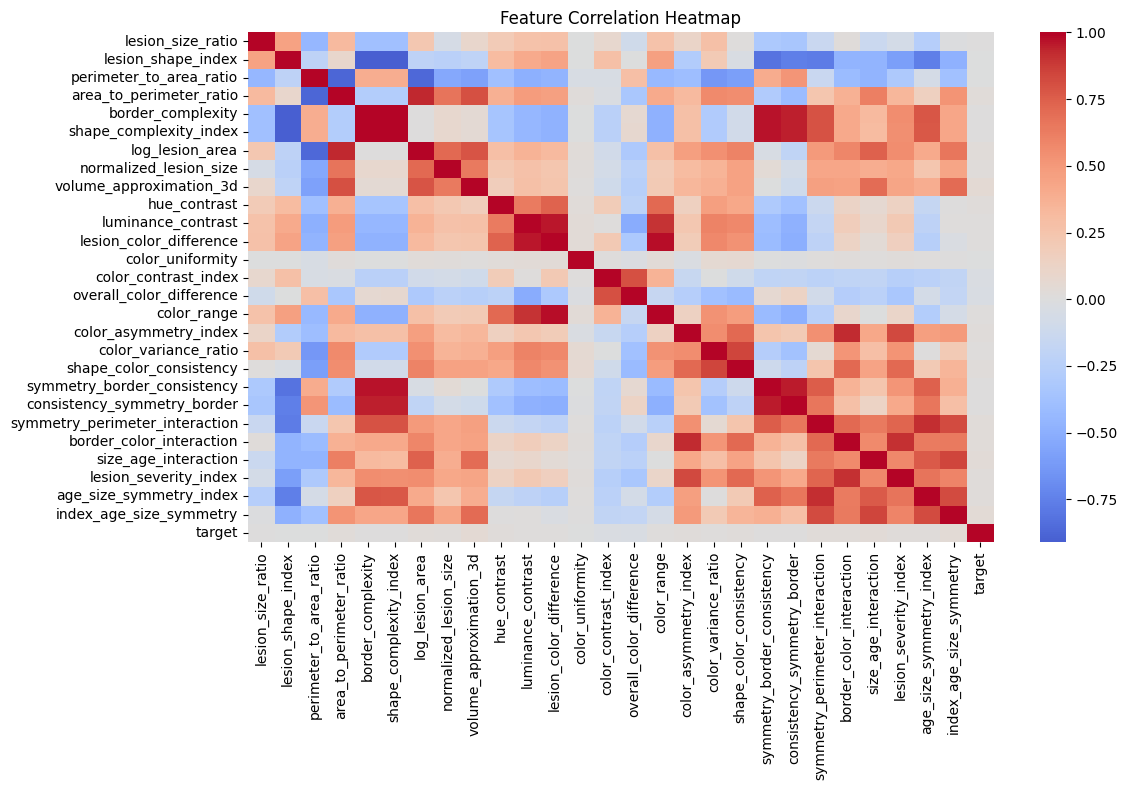

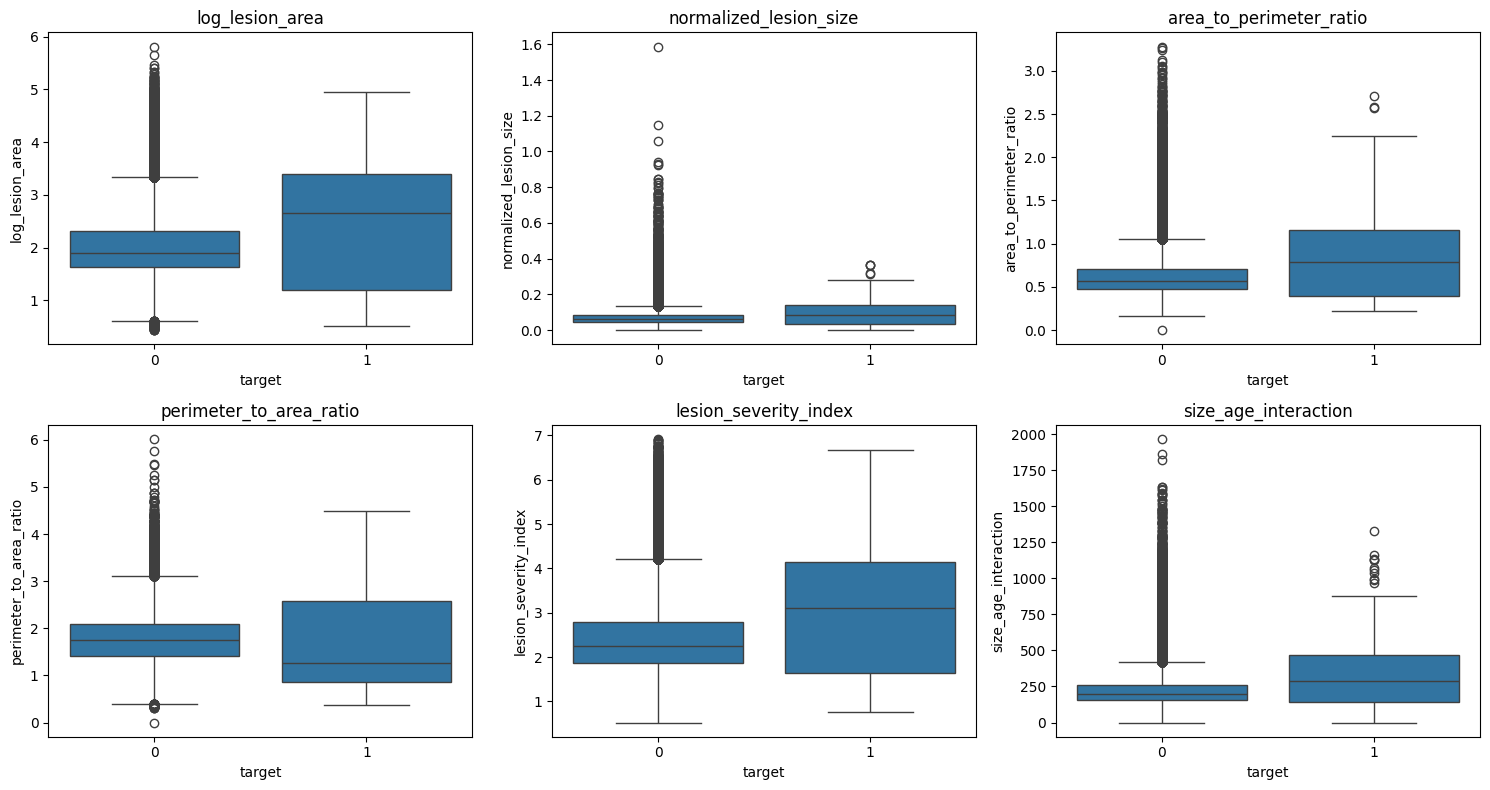

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv("subject_data.csv")

# Ensure needed columns exist
def safe_div(a, b):
    return np.where(b != 0, a / b, 0)

def safe_sqrt(x):
    return np.sqrt(np.clip(x, 0, None))

# Feature engineering
df['lesion_size_ratio'] = safe_div(df['tbp_lv_minorAxisMM'], df['clin_size_long_diam_mm'])
df['lesion_shape_index'] = safe_div(df['tbp_lv_areaMM2'], df['tbp_lv_perimeterMM']**2)
df['hue_contrast'] = np.abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
df['luminance_contrast'] = np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext'])
df['lesion_color_difference'] = safe_sqrt(df['tbp_lv_deltaA']**2 + df['tbp_lv_deltaB']**2 + df['tbp_lv_deltaL']**2)
df['border_complexity'] = df['tbp_lv_norm_border'] + df['tbp_lv_symm_2axis']
df['color_uniformity'] = safe_div(df['tbp_lv_color_std_mean'], df['tbp_lv_radial_color_std_max'])
df['position_distance_3d'] = safe_sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2)
df['perimeter_to_area_ratio'] = safe_div(df['tbp_lv_perimeterMM'], df['tbp_lv_areaMM2'])
df['area_to_perimeter_ratio'] = safe_div(df['tbp_lv_areaMM2'], df['tbp_lv_perimeterMM'])
df['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
df['symmetry_border_consistency'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']
df['consistency_symmetry_border'] = safe_div(df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border'],
                                             (df['tbp_lv_symm_2axis'] + df['tbp_lv_norm_border']))
df['color_consistency'] = safe_div(df['tbp_lv_stdL'], df['tbp_lv_Lext'])
df['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
df['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
df['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
df['shape_complexity_index'] = df['border_complexity'] + df['lesion_shape_index']
df['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']
df['log_lesion_area'] = np.log1p(df['tbp_lv_areaMM2'])
df['normalized_lesion_size'] = safe_div(df['clin_size_long_diam_mm'], df['age_approx'])
df['overall_color_difference'] = (df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL']) / 3
df['symmetry_perimeter_interaction'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_perimeterMM']
df['color_variance_ratio'] = safe_div(df['tbp_lv_color_std_mean'], df['tbp_lv_stdLExt'])
df['border_color_interaction'] = df['tbp_lv_norm_border'] * df['tbp_lv_norm_color']
df['color_asymmetry_index'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_radial_color_std_max']
df['volume_approximation_3d'] = df['tbp_lv_areaMM2'] * safe_sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2)
df['color_range'] = (np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext']) +
                     np.abs(df['tbp_lv_A'] - df['tbp_lv_Aext']) +
                     np.abs(df['tbp_lv_B'] - df['tbp_lv_Bext']))
df['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
df['age_size_symmetry_index'] = df['age_approx'] * df['clin_size_long_diam_mm'] * df['tbp_lv_symm_2axis']
df['index_age_size_symmetry'] = df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis']

# Select top 30 engineered features for analysis
eng_cols = [
    'lesion_size_ratio','lesion_shape_index','perimeter_to_area_ratio','area_to_perimeter_ratio','border_complexity',
    'shape_complexity_index','border_length_ratio' if 'border_length_ratio' in df else None,
    'log_lesion_area','normalized_lesion_size','volume_approximation_3d',
    'hue_contrast','luminance_contrast','lesion_color_difference','color_uniformity',
    'color_contrast_index','overall_color_difference','color_range','color_asymmetry_index',
    'color_variance_ratio','shape_color_consistency','symmetry_border_consistency','consistency_symmetry_border',
    'symmetry_perimeter_interaction','border_color_interaction','size_age_interaction',
    'lesion_severity_index','color_shape_composite_index' if 'color_shape_composite_index' in df else None,
    'age_size_symmetry_index','index_age_size_symmetry'
]
eng_cols = [c for c in eng_cols if c in df.columns]

# Drop NA for MI calculation
df_clean = df[eng_cols + ['target']].fillna(0)

# Compute correlations
corrs = df_clean.corr()['target'].sort_values(key=lambda x: abs(x), ascending=False)
print("Top features by Pearson correlation:\n", corrs.head(15))

# Mutual Information ranking
mi_scores = mutual_info_classif(df_clean[eng_cols], df_clean['target'])
mi_df = pd.DataFrame({'feature': eng_cols, 'MI': mi_scores}).sort_values('MI', ascending=False)
print("\nTop features by mutual information:\n", mi_df.head(15))

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_clean[eng_cols + ['target']].corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Boxplots for top MI features
top_feats = mi_df['feature'].head(6)
fig, axes = plt.subplots(2, 3, figsize=(15,8))
for ax, feat in zip(axes.flatten(), top_feats):
    sns.boxplot(x='target', y=feat, data=df_clean, ax=ax)
    ax.set_title(feat)
plt.tight_layout()
plt.show()


In [ ]:
# fast_feature_ranking.py
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr

DATA = Path("subject_data.csv")
OUT = Path(".")
N_NEG_SAMPLE = 5000   # set smaller if memory is tight

# Robust CSV read
df = pd.read_csv(DATA, engine='python', on_bad_lines='skip')

# --- feature engineering (safe, only if base columns exist) ---
def safe_div(a, b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        out = np.where((b == 0) | np.isnan(b), 0.0, a / b)
    return out

def safe_sqrt(x):
    x = np.array(x, dtype=float); return np.sqrt(np.clip(x, 0, None))

E = {}
cols = set(df.columns)
has = lambda c: c in cols

# create a subset of engineered features (same set as before)
if has('tbp_lv_minorAxisMM') and has('clin_size_long_diam_mm'):
    E['lesion_size_ratio'] = safe_div(df['tbp_lv_minorAxisMM'], df['clin_size_long_diam_mm'])
if has('tbp_lv_areaMM2') and has('tbp_lv_perimeterMM'):
    E['lesion_shape_index'] = safe_div(df['tbp_lv_areaMM2'], df['tbp_lv_perimeterMM']**2)
if has('tbp_lv_H') and has('tbp_lv_Hext'):
    E['hue_contrast'] = np.abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
if has('tbp_lv_L') and has('tbp_lv_Lext'):
    E['luminance_contrast'] = np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext'])
if all(has(c) for c in ['tbp_lv_deltaA','tbp_lv_deltaB','tbp_lv_deltaL']):
    E['lesion_color_difference'] = safe_sqrt(df['tbp_lv_deltaA']**2 + df['tbp_lv_deltaB']**2 + df['tbp_lv_deltaL']**2)
if has('tbp_lv_norm_border') and has('tbp_lv_symm_2axis'):
    E['border_complexity'] = df['tbp_lv_norm_border'].fillna(0) + df['tbp_lv_symm_2axis'].fillna(0)
if has('tbp_lv_color_std_mean') and has('tbp_lv_radial_color_std_max'):
    E['color_uniformity'] = safe_div(df['tbp_lv_color_std_mean'], df['tbp_lv_radial_color_std_max'])
if all(has(c) for c in ['tbp_lv_x','tbp_lv_y','tbp_lv_z']):
    E['position_distance_3d'] = safe_sqrt(df['tbp_lv_x']**2 + df['tbp_lv_y']**2 + df['tbp_lv_z']**2)
if has('tbp_lv_perimeterMM') and has('tbp_lv_areaMM2'):
    E['perimeter_to_area_ratio'] = safe_div(df['tbp_lv_perimeterMM'], df['tbp_lv_areaMM2'])
    E['area_to_perimeter_ratio'] = safe_div(df['tbp_lv_areaMM2'], df['tbp_lv_perimeterMM'])
if has('tbp_lv_deltaLBnorm') and has('tbp_lv_norm_color'):
    E['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'].fillna(0) + df['tbp_lv_norm_color'].fillna(0)
if has('tbp_lv_symm_2axis') and has('tbp_lv_norm_border'):
    E['symmetry_border_consistency'] = df['tbp_lv_symm_2axis'].fillna(0) * df['tbp_lv_norm_border'].fillna(0)
    denom = (df['tbp_lv_symm_2axis'].fillna(0) + df['tbp_lv_norm_border'].fillna(0))
    E['consistency_symmetry_border'] = safe_div(df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border'], denom)
if has('tbp_lv_stdL') and has('tbp_lv_Lext'):
    E['color_consistency'] = safe_div(df['tbp_lv_stdL'], df['tbp_lv_Lext'])
if has('clin_size_long_diam_mm') and has('age_approx'):
    E['size_age_interaction'] = df['clin_size_long_diam_mm'].fillna(0) * df['age_approx'].fillna(0)
if has('tbp_lv_H') and has('tbp_lv_color_std_mean'):
    E['hue_color_std_interaction'] = df['tbp_lv_H'].fillna(0) * df['tbp_lv_color_std_mean'].fillna(0)
if all(has(c) for c in ['tbp_lv_norm_border','tbp_lv_norm_color','tbp_lv_eccentricity']):
    E['lesion_severity_index'] = (df['tbp_lv_norm_border'].fillna(0) + df['tbp_lv_norm_color'].fillna(0) + df['tbp_lv_eccentricity'].fillna(0)) / 3
# other safe features
if has('tbp_lv_areaMM2'):
    E['log_lesion_area'] = np.log1p(df['tbp_lv_areaMM2'].fillna(0))
if has('clin_size_long_diam_mm') and has('age_approx'):
    E['normalized_lesion_size'] = safe_div(df['clin_size_long_diam_mm'], df['age_approx'])
if all(has(c) for c in ['tbp_lv_deltaA','tbp_lv_deltaB','tbp_lv_deltaL','tbp_lv_deltaLBnorm']):
    E['color_contrast_index'] = df['tbp_lv_deltaA'].fillna(0) + df['tbp_lv_deltaB'].fillna(0) + df['tbp_lv_deltaL'].fillna(0) + df['tbp_lv_deltaLBnorm'].fillna(0)
if all(has(c) for c in ['tbp_lv_L','tbp_lv_Lext','tbp_lv_A','tbp_lv_Aext','tbp_lv_B','tbp_lv_Bext']):
    E['color_range'] = (np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext']).fillna(0) + np.abs(df['tbp_lv_A'] - df['tbp_lv_Aext']).fillna(0) + np.abs(df['tbp_lv_B'] - df['tbp_lv_Bext']).fillna(0))
if all(has(c) for c in ['tbp_lv_symm_2axis','tbp_lv_radial_color_std_max']):
    E['color_asymmetry_index'] = df['tbp_lv_symm_2axis'].fillna(0) * df['tbp_lv_radial_color_std_max'].fillna(0)
if all(has(c) for c in ['tbp_lv_color_std_mean','tbp_lv_stdLExt']):
    E['color_variance_ratio'] = safe_div(df['tbp_lv_color_std_mean'], df['tbp_lv_stdLExt'])
if all(has(c) for c in ['tbp_lv_eccentricity','tbp_lv_color_std_mean']):
    E['shape_color_consistency'] = df['tbp_lv_eccentricity'].fillna(0) * df['tbp_lv_color_std_mean'].fillna(0)
if all(has(c) for c in ['age_approx','clin_size_long_diam_mm','tbp_lv_symm_2axis']):
    E['age_size_symmetry_index'] = df['age_approx'].fillna(0) * df['clin_size_long_diam_mm'].fillna(0) * df['tbp_lv_symm_2axis'].fillna(0)
if all(has(c) for c in ['age_approx','tbp_lv_areaMM2','tbp_lv_symm_2axis']):
    E['index_age_size_symmetry'] = df['age_approx'].fillna(0) * df['tbp_lv_areaMM2'].fillna(0) * df['tbp_lv_symm_2axis'].fillna(0)

E = pd.DataFrame(E)
eng_cols = list(E.columns)
print(f"Engineered features created: {len(eng_cols)} -> {eng_cols}")

# labels and subsample
y = df['target'].fillna(0).astype(int).values
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == 0)[0]

# sample negatives
if len(neg_idx) > N_NEG_SAMPLE:
    rng = np.random.RandomState(42)
    neg_pick = rng.choice(neg_idx, N_NEG_SAMPLE, replace=False)
else:
    neg_pick = neg_idx
sample_idx = np.concatenate([pos_idx, neg_pick])

Xs = E.loc[sample_idx].fillna(0).astype(float)
ys = y[sample_idx]

# impute medians (safe)
imp = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imp.fit_transform(Xs), columns=eng_cols)

# compute metrics
mi = mutual_info_classif(X_imp, ys, discrete_features=False, random_state=42)
pearson_r = []
auc = []
for f in eng_cols:
    try:
        r, _ = pearsonr(X_imp[f], ys)
    except Exception:
        r = 0.0
    pearson_r.append(r)
    try:
        a = roc_auc_score(ys, X_imp[f])
    except Exception:
        a = float('nan')
    auc.append(a)

summary = pd.DataFrame({'feature': eng_cols, 'mutual_info': mi, 'pearson_r': pearson_r, 'auc': auc})
summary = summary.sort_values('mutual_info', ascending=False).reset_index(drop=True)
summary.to_csv(OUT / "engineered_features_ranking_subsample.csv", index=False)

print("Top features by mutual information:")
print(summary[['feature','mutual_info','auc','pearson_r']].head(15).to_string(index=False))


Engineered features created: 26 -> ['lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference', 'border_complexity', 'color_uniformity', 'position_distance_3d', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio', 'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency', 'size_age_interaction', 'hue_color_std_interaction', 'lesion_severity_index', 'log_lesion_area', 'normalized_lesion_size', 'color_contrast_index', 'color_range', 'color_asymmetry_index', 'color_variance_ratio', 'shape_color_consistency', 'age_size_symmetry_index', 'index_age_size_symmetry']
Top features by mutual information:
                  feature  mutual_info      auc  pearson_r
          log_lesion_area     0.073613 0.618712   0.181502
   normalized_lesion_size     0.054908 0.576025   0.154595
  perimeter_to_area_ratio     0.050152 0.399723  -0.023176
  area_to_perimeter_ratio     0.050056 0.600277   0.226899
    

/tmp/ipython-input-3551185592.py:7: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("subject_data.csv")
/tmp/ipython-input-3551185592.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='target', y=feat, inner='quart', palette='Set2', cut=0)
/tmp/ipython-input-3551185592.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_plot, x='target', y=feat, inner='quart', palette='Set2', cut=0)
/tmp/ipython-input-3551185592.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for t

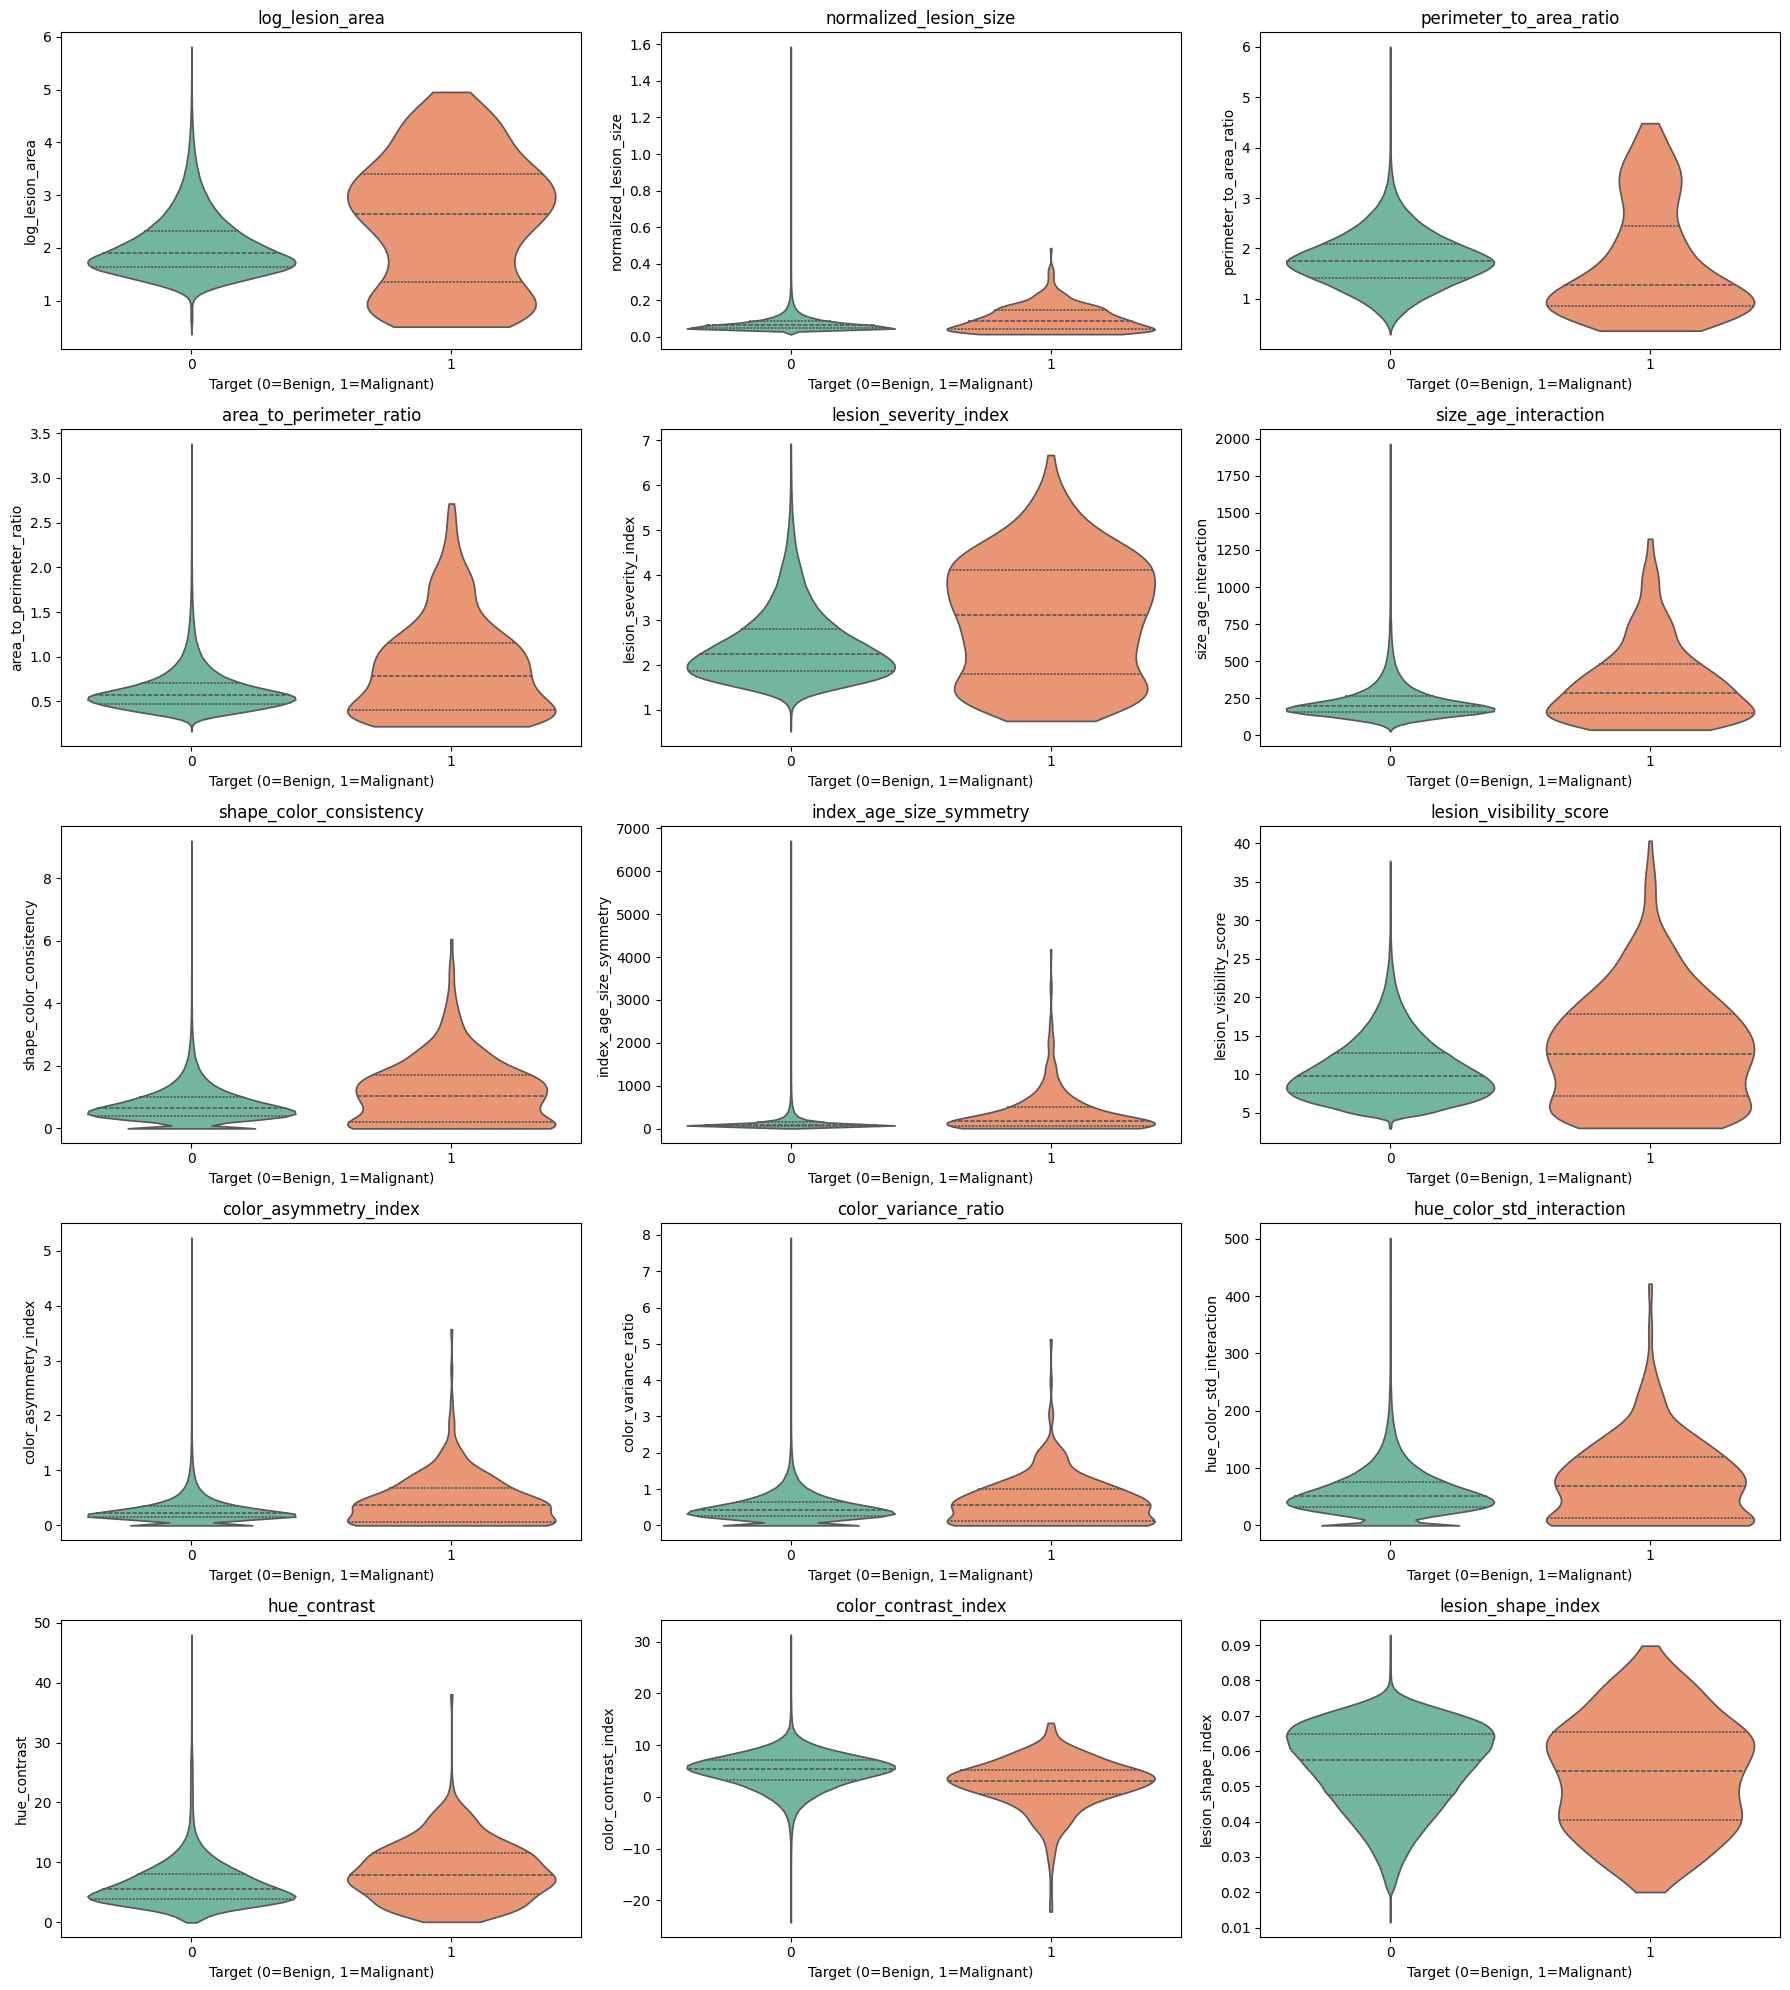

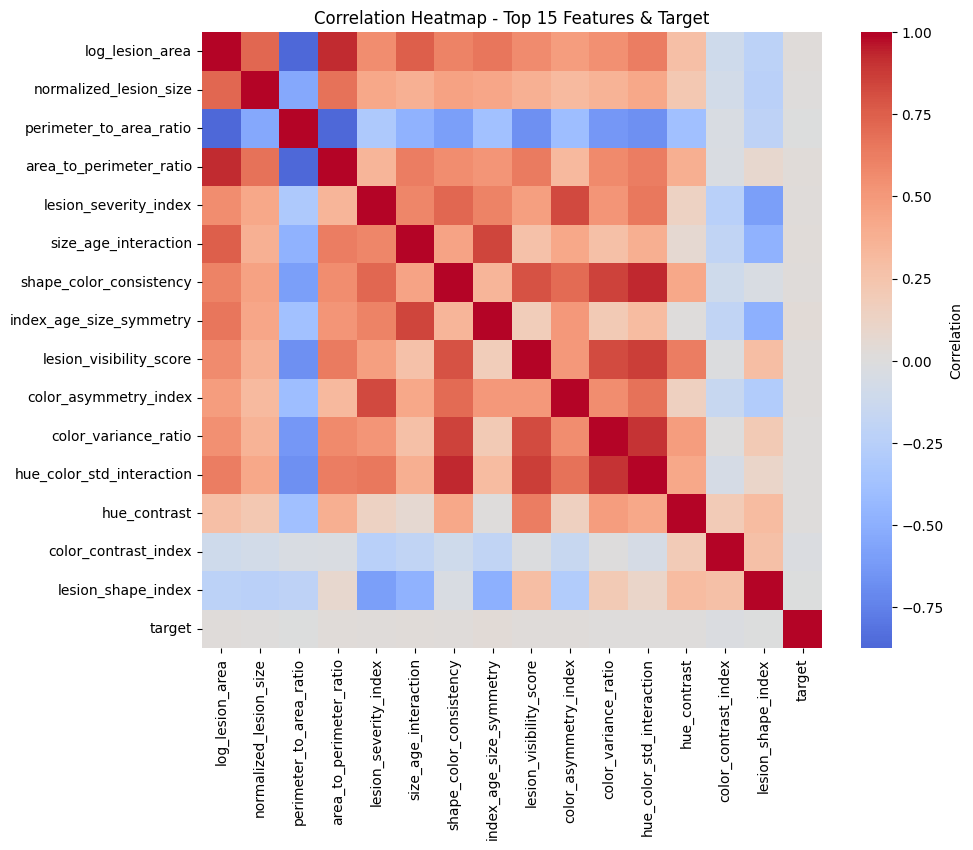

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("subject_data.csv")

# Feature engineering functions (only those needed for top 15)
df['log_lesion_area'] = np.log(df['tbp_lv_areaMM2'] + 1)
df['normalized_lesion_size'] = df['clin_size_long_diam_mm'] / (df['age_approx'] + 1e-3)
df['perimeter_to_area_ratio'] = df['tbp_lv_perimeterMM'] / (df['tbp_lv_areaMM2'] + 1e-3)
df['area_to_perimeter_ratio'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] + 1e-3)
df['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
df['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
df['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
df['index_age_size_symmetry'] = df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis']
df['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
df['color_asymmetry_index'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_radial_color_std_max']
df['color_variance_ratio'] = df['tbp_lv_color_std_mean'] / (df['tbp_lv_stdLExt'] + 1e-3)
df['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
df['hue_contrast'] = abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
df['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']
df['lesion_shape_index'] = df['tbp_lv_areaMM2'] / ((df['tbp_lv_perimeterMM'] ** 2) + 1e-3)

# Keep only target and engineered features
top_features = [
    'log_lesion_area', 'normalized_lesion_size', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio',
    'lesion_severity_index', 'size_age_interaction', 'shape_color_consistency', 'index_age_size_symmetry',
    'lesion_visibility_score', 'color_asymmetry_index', 'color_variance_ratio', 'hue_color_std_interaction',
    'hue_contrast', 'color_contrast_index', 'lesion_shape_index'
]

# Drop rows with NaN in top features
df_plot = df.dropna(subset=top_features + ['target'])

# ==== Violin Plots ====
ncols = 3
nrows = int(np.ceil(len(top_features) / ncols))
plt.figure(figsize=(6 * ncols, 4 * nrows))

for i, feat in enumerate(top_features, 1):
    plt.subplot(nrows, ncols, i)
    sns.violinplot(data=df_plot, x='target', y=feat, inner='quart', palette='Set2', cut=0)
    plt.title(feat)
    plt.xlabel("Target (0=Benign, 1=Malignant)")
    plt.ylabel(feat)

plt.tight_layout()
plt.show()

# ==== Correlation Heatmap ====
corr = df_plot[top_features + ['target']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Heatmap - Top 15 Features & Target")
plt.show()



In [1]:
import pandas as pd
import numpy as np

# Load original dataset
df = pd.read_csv("subject_data.csv")

# ---- Feature Engineering ----
df['log_lesion_area'] = np.log(df['tbp_lv_areaMM2'] + 1)
df['normalized_lesion_size'] = df['clin_size_long_diam_mm'] / (df['age_approx'] + 1e-3)
df['perimeter_to_area_ratio'] = df['tbp_lv_perimeterMM'] / (df['tbp_lv_areaMM2'] + 1e-3)
df['area_to_perimeter_ratio'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] + 1e-3)
df['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
df['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
df['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
df['index_age_size_symmetry'] = df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis']
df['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
df['color_asymmetry_index'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_radial_color_std_max']
df['color_variance_ratio'] = df['tbp_lv_color_std_mean'] / (df['tbp_lv_stdLExt'] + 1e-3)
df['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
df['hue_contrast'] = abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
df['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']
df['lesion_shape_index'] = df['tbp_lv_areaMM2'] / ((df['tbp_lv_perimeterMM'] ** 2) + 1e-3)

# Save combined dataset with engineered features
df.to_csv("subject_data_with_engineered_features.csv", index=False)

print("✅ Combined dataset saved as subject_data_with_engineered_features.csv")


/tmp/ipython-input-3574114229.py:5: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("subject_data.csv")


✅ Combined dataset saved as subject_data_with_engineered_features.csv


In [4]:
import pandas as pd

# Try reading with error handling
df_main = pd.read_csv("subject_data.csv", on_bad_lines="skip", engine="python")
df_features = pd.read_csv("engineered_features.csv")

# Merge — assuming same number of rows & order
df_merged = pd.concat([df_main.reset_index(drop=True),
                       df_features.reset_index(drop=True)], axis=1)

df_merged.to_csv("subject_data_with_features.csv", index=False)
print(df_merged.shape)


/tmp/ipython-input-2135338225.py:5: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_features = pd.read_csv("engineered_features.csv")


(401059, 125)


POOP - IMG SE DATA EXTRACTION

In [ ]:
import gdown

gdown.download_folder('https://drive.google.com/drive/folders/1UKUZZ6uTdEVdGWEKNh0ZRp08pK_AVnrm', output='Download')

In [ ]:
import gdown
import pandas as pd
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import os

# typeshi Config
GDRIVE_FOLDER_ID = '1UKUZZ6uTdEVdGWEKNh0ZRp08pK_AVnrm'
DOWNLOAD_PATH = 'DownloadedData'
TABULAR_DATA_FILE = os.path.join(DOWNLOAD_PATH, 'subject_data.csv')
IMAGE_DATA_FILE = os.path.join(DOWNLOAD_PATH, 'images.hdf5')
FUSED_DATA_OUTPUT_FILE = 'fused_data.pkl' # Using pickle is faster for large dataframes

# ResNet50 expects 224x224 images
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32 # Adjustable

# Download the Dataset in here
def download_data():
    """Downloads the dataset folder from Google Drive if not already present."""
    if not os.path.exists(DOWNLOAD_PATH):
        print(f"Downloading data folder to '{DOWNLOAD_PATH}'...")
        os.makedirs(DOWNLOAD_PATH)
        gdown.download_folder(id=GDRIVE_FOLDER_ID, output=DOWNLOAD_PATH, quiet=False)
        print("Download complete.")
    else:
        print("Data folder already exists. Skipping download.")

# Load and Prepare ResNet50 Model
def load_feature_extractor():
    """Loads the ResNet50 model, removing its top classification layer."""
    print("Loading pre-trained ResNet50 model...")
    # Load ResNet50 trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    # 'pooling=avg' gives us a flat 2048-feature vector directly
    print("Model loaded successfully.")
    return base_model

# Main Execution Block
if __name__ == "__main__":
    download_data()

    # Load the tabular data to get the list of images to process
    print(f"Loading tabular data from '{TABULAR_DATA_FILE}'...")
    df_tabular = pd.read_csv(TABULAR_DATA_FILE)
    # Get the unique identifiers that we need to find in the HDF5 file
    image_ids = df_tabular['isic_id'].unique().tolist()
    print(f"Found {len(image_ids)} unique image IDs to process.")

    # Load the feature extraction model
    model = load_feature_extractor()

    # Prepare lists to store the results
    all_features = []
    processed_ids = []

    print(f"Starting feature extraction with batch size {BATCH_SIZE}...")
    # Open the HDF5 file once to avoid repeated file I/O
    with h5py.File(IMAGE_DATA_FILE, 'r') as hdf5_file:

        # Process the images in batches for efficiency
        for i in tqdm(range(0, len(image_ids), BATCH_SIZE), desc="Extracting Features"):
            batch_ids = image_ids[i:i + BATCH_SIZE]
            batch_images = []

            for img_id in batch_ids:
                try:
                    # Access the image data using its ID as the key
                    img_data = hdf5_file[img_id][()]

                    # Convert to a TensorFlow tensor and resize
                    img = tf.image.decode_jpeg(img_data, channels=3)
                    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
                    batch_images.append(img)
                except KeyError:
                    print(f"\nWarning: Image ID '{img_id}' not found in HDF5 file. Skipping.")
                except Exception as e:
                    print(f"\nError processing image '{img_id}': {e}. Skipping.")

            if not batch_images:
                continue

            # Convert the list of images to a single numpy array
            batch_images_np = np.array(batch_images)

            # Apply ResNet-specific preprocessing
            batch_images_preprocessed = preprocess_input(batch_images_np)

            # Predict (extract features) for the entire batch
            batch_features = model.predict(batch_images_preprocessed, verbose=0)

            # Store the results
            all_features.extend(batch_features)
            processed_ids.extend(batch_ids)

    print("\nFeature extraction complete.")

    # --- Step 4: Create Feature DataFrame and Merge ---
    print("Creating feature DataFrame and merging with tabular data...")

    # Create column names for the new features
    feature_columns = [f'resnet_feat_{i}' for i in range(model.output_shape[1])]

    # Create the DataFrame of image features
    df_features = pd.DataFrame(all_features, columns=feature_columns)
    df_features['isic_id'] = processed_ids

    # Merge the image features with the original tabular data
    # Using an inner merge ensures that only records with both tabular and image data are kept
    df_fused = pd.merge(df_tabular, df_features, on='isic_id', how='inner')

    print("Merge complete.")
    print(f"Original tabular shape: {df_tabular.shape}")
    print(f"New fused data shape:   {df_fused.shape}")

    # --- Step 5: Save the Fused Dataset ---
    print(f"Saving the final fused dataset to '{FUSED_DATA_OUTPUT_FILE}'...")
    # Using pickle preserves data types and is generally more efficient for DataFrames
    df_fused.to_pickle(FUSED_DATA_OUTPUT_FILE)

    print("\nMission Accomplished: Your data is now fused with powerful image features.")
    print("You can now load 'fused_data.pkl' for model training.")
    print(df_fused.head())

In [ ]:
import gdown
import os
import h5py
import cv2
import numpy as np
from PIL import Image
from skimage.filters import gabor
from skimage.feature import greycomatrix, greycoprops


### STEP 1: DOWNLOAD DATA FROM GOOGLE DRIVE
gdown.download_folder('https://drive.google.com/drive/folders/1UKUZZ6uTdEVdGWEKNh0ZRp08pK_AVnrm', output='Download')


### STEP 2: HELPER FUNCTIONS FOR IMAGE FEATURE EXTRACTION

def compute_blur_score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def compute_color_asymmetry(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[:, :, 0]
    center = h[h.shape[0]//4:3*h.shape[0]//4, h.shape[1]//4:3*h.shape[1]//4]
    border = np.concatenate([
        h[:h.shape[0]//4, :].flatten(),
        h[3*h.shape[0]//4:, :].flatten(),
        h[:, :h.shape[1]//4].flatten(),
        h[:, 3*h.shape[1]//4:].flatten()
    ])
    return np.var(center) - np.var(border)

def compute_blue_white_veil(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    b_channel = lab[:, :, 2]
    mask = (b_channel > 150) & (b_channel < 200)
    return np.sum(mask) / mask.size

def compute_gabor_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    filt_real, _ = gabor(gray, frequency=0.6)
    return np.mean(filt_real), np.var(filt_real)

def compute_glcm_texture(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    glcm = greycomatrix(gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        'texture_contrast': greycoprops(glcm, 'contrast')[0, 0],
        'texture_dissimilarity': greycoprops(glcm, 'dissimilarity')[0, 0],
        'texture_homogeneity': greycoprops(glcm, 'homogeneity')[0, 0],
        'texture_asm': greycoprops(glcm, 'ASM')[0, 0],
        'texture_energy': greycoprops(glcm, 'energy')[0, 0],
        'texture_correlation': greycoprops(glcm, 'correlation')[0, 0],
    }

def preprocess_image(arr):
    """Convert to uint8 and resize if needed."""
    arr = (arr * 255).astype(np.uint8) if arr.max() <= 1.0 else arr.astype(np.uint8)
    if arr.shape[-1] == 1:
        arr = np.repeat(arr, 3, axis=-1)
    return arr

def extract_features_from_array(img_array):
    img = preprocess_image(img_array)
    features = {
        'blur_score': compute_blur_score(img),
        'color_asymmetry': compute_color_asymmetry(img),
        'blue_white_veil_score': compute_blue_white_veil(img),
    }
    g_mean, g_var = compute_gabor_features(img)
    features['gabor_mean'] = g_mean
    features['gabor_variance'] = g_var
    features.update(compute_glcm_texture(img))
    return features


### STEP 3: LOAD IMAGES FROM HDF5 FILE

hdf5_path = "Download/images.h5"  # adjust this if needed
with h5py.File(hdf5_path, "r") as h5f:
    print("Keys found in file:", list(h5f.keys()))
    image_data = h5f['images']  # or adjust based on the actual key
    print("Image shape:", image_data.shape)

    results = []
    for idx in range(image_data.shape[0]):
        img_array = image_data[idx]
        feat = extract_features_from_array(img_array)
        feat["image_index"] = idx
        results.append(feat)

import pandas as pd
df = pd.DataFrame(results)
df.to_csv("extracted_image_features.csv", index=False)
print("Extracted features saved to extracted_image_features.csv")
